In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import gurobipy as gp
from gurobipy import GRB
import scipy
from ast import literal_eval
import json
import tqdm

In [13]:
rng = np.random.default_rng(9870)

## Simulation Code

In [14]:
def simulation(params, n, beta=1.0, tmax=100, ts=10, plot=False, initial_state=(0, 0)):
    '''
    Simulate a sample path of the birth death regulation model
    Sample n values at intervals of ts after a burn-in time of tmax

    params: dict of reaction rate constants
    n: number of samples
    beta: capture efficiency, list of length n (per cell) or single value
    tmax: burn in time
    ts: time between samples
    '''

    # initialise time and state
    t = 0
    path = [initial_state]
    jump_times = [0]

    # simulate for burn-in time and time between n samples
    while t < tmax + (n - 1) * ts:

        # current state
        x1, x2 = path[-1][0], path[-1][1]

        # transition rates
        q_tx_1 = params['k_tx_1']
        q_tx_2 = params['k_tx_2']
        q_deg_1 = x1 * params['k_deg_1']
        q_deg_2 = x2 * params['k_deg_2']
        q_reg = x1 * x2 * params['k_reg']
        q_hold = q_tx_1 + q_tx_2 + q_deg_1 + q_deg_2 + q_reg

        # holding time in current state
        t_hold = -np.log(rng.uniform()) / q_hold
        t += t_hold
        jump_times.append(t)

        # jump probability
        outcome = [1, 2, 3, 4, 5]
        prob = [
            q_tx_1 / q_hold,
            q_tx_2 / q_hold,
            q_deg_1 / q_hold,
            q_deg_2 / q_hold,
            q_reg / q_hold
        ]
        jump = rng.choice(outcome, p=prob)
        match jump:
            case 1:
                path.append((x1 + 1, x2))
            case 2:
                path.append((x1, x2 + 1))
            case 3:
                path.append((x1 - 1, x2))
            case 4:
                path.append((x1, x2 - 1))
            case 5:
                path.append((x1 - 1, x2 - 1))

    # take the transcript states
    x1_path = [state[0] for state in path]
    x2_path = [state[1] for state in path]

    # create step function of sample path from jump times and jump values
    x1_path_function = scipy.interpolate.interp1d(jump_times, x1_path, kind='previous')
    x2_path_function = scipy.interpolate.interp1d(jump_times, x2_path, kind='previous')

    # take values at sampling times as samples from stationary dist
    sample_times = [tmax + i * ts for i in range(n)]
    x1_samples = x1_path_function(sample_times)
    x2_samples = x2_path_function(sample_times)

    # convert to integers
    x1_samples = [int(x1) for x1 in x1_samples]
    x2_samples = [int(x2) for x2 in x2_samples]

    # apply capture efficiency: for each count, draw from Binomial(count, beta)
    x1_samples_beta = np.random.binomial(x1_samples, beta).tolist()
    x2_samples_beta = np.random.binomial(x2_samples, beta).tolist()

    # re-combine to pairs of samples
    samples = list(zip(x1_samples, x2_samples))
    samples_beta = list(zip(x1_samples_beta, x2_samples_beta))

    # plot sample paths
    if plot:
        x = np.linspace(0, tmax + (n - 1) * ts, 10000)
        plt.plot(x, x1_path_function(x), label="X1 sample path", color="blue")
        plt.plot(x, x2_path_function(x), label="X2 sample path", color="purple")
        #plt.axvline(tmax, label="Burn-in time", color="orange")
        plt.xlabel("Time")
        plt.ylabel("# molcules")
        plt.legend()
        plt.show()

    # collect all sample paths: original and observed
    data = {
        'x1_OG': x1_samples,
        'x2_OG': x2_samples,
        'OG': samples,
        'x1_OB': x1_samples_beta,
        'x2_OB': x2_samples_beta,
        'OB': samples_beta
    }

    return data

# Bootstrap Investigation

Bootstrap re-sampling is used to compute confidence intervals on the distribution of observed data (denoted q) which are then used as input for optimization.

However, the data is observed as pairs of counts $(x_{1}, x_{2})$ so we can either take 'pairwise' bootstrap samples, or 'independent' bootstrap samples.

## Comparison: Pairwise vs Individual Bootstrap

What is the difference between resampling from pairs of counts then splitting pairs to compute marginals, and splitting pairs then resampling from individual counts.

In [15]:
def pairwise_bootstrap(samples, BS=1000):
    '''Resample pairwise, then split'''

    # max states and sample size
    M, N = np.max(samples, axis=0)
    M, N = int(M), int(N)
    n = len(samples)

    # distribution estimates
    estimates_x1 = [[] for x1 in range(M + 1)]
    estimates_x2 = [[] for x2 in range(N + 1)]

    for b in range(BS):

        # bootstrap resample: pairwise
        resamples = rng.choice(samples, size=n)

        # split
        resamples_x1 = [x[0] for x in resamples]
        resamples_x2 = [x[1] for x in resamples]

        # compute estimates
        for x1 in range(M + 1):
            estimates_x1[x1].append(resamples_x1.count(x1) / n)
        for x2 in range(N + 1):
            estimates_x2[x2].append(resamples_x2.count(x2) / n)

    # for each estimated value take quantiles as CI
    bounds_x1 = [np.quantile(estimates, [0.025, 0.975]) for estimates in estimates_x1]
    bounds_x2 = [np.quantile(estimates, [0.025, 0.975]) for estimates in estimates_x2]

    results = {
        'x1': bounds_x1,
        'x2': bounds_x2
    }

    return results

In [16]:
def individual_bootstrap(samples, BS=1000):
    '''Split, then resample counts individually'''

    # max states and sample size
    M, N = np.max(samples, axis=0)
    M, N = int(M), int(N)
    n = len(samples)

    # distribution estimates
    estimates_x1 = [[] for x1 in range(M + 1)]
    estimates_x2 = [[] for x2 in range(N + 1)]

    # split
    samples_x1 = [x[0] for x in samples]
    samples_x2 = [x[1] for x in samples]

    for b in range(BS):

        # bootstrap resample: x1 counts only
        resamples_x1 = list(rng.choice(samples_x1, size=n))

        # compute estimates
        for x1 in range(M + 1):
            estimates_x1[x1].append(resamples_x1.count(x1) / n)

        # bootstrap resample: x2 counts only
        resamples_x2 = list(rng.choice(samples_x2, size=n))

        for x2 in range(N + 1):
            estimates_x2[x2].append(resamples_x2.count(x2) / n)

    # for each estimated value take quantiles as CI
    bounds_x1 = [np.quantile(estimates, [0.025, 0.975]) for estimates in estimates_x1]
    bounds_x2 = [np.quantile(estimates, [0.025, 0.975]) for estimates in estimates_x2]

    results = {
        'x1': bounds_x1,
        'x2': bounds_x2
    }

    return results

In [33]:
params = {
    'k_tx_1': 10,
    'k_tx_2': 5,
    'k_deg_1': 1,
    'k_deg_2': 0.5,
    'k_reg': 5
}

n = 1000

samples = simulation(params, n=n, beta=0.5)

In [34]:
pairwise_bounds = pairwise_bootstrap(samples['OB'], BS=1000)
individual_bounds = individual_bootstrap(samples['OB'], BS=1000)

In [35]:
#bounds = bootstrap(samples['OB'], BS=1000, thresh_OB=0, plot=False, printing=False)

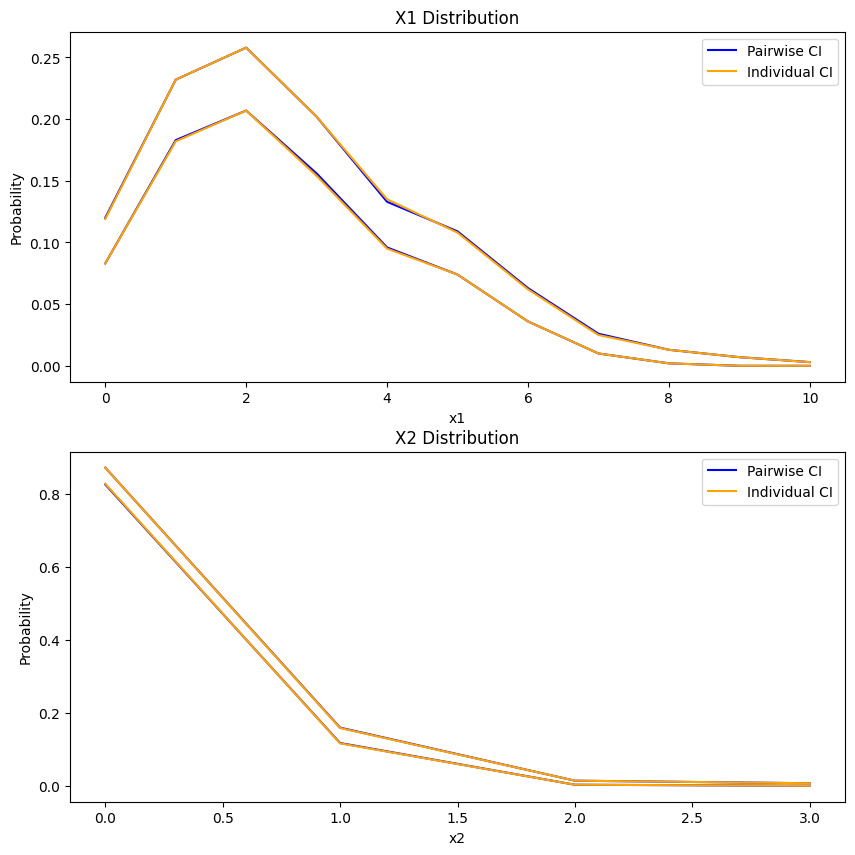

In [36]:
# size information
M, N = np.max(samples['OB'], axis=0)
M, N = int(M), int(N)

# true marginal distributions (ONLY POISSON IF NO INTERACTION)
if params['k_reg'] == 0 and beta == 1.0:
    true_dist_x1 = [scipy.stats.poisson.pmf(x1, params['k_tx_1'] / params['k_deg_1']) for x1 in range(M + 1)]
    true_dist_x2 = [scipy.stats.poisson.pmf(x2, params['k_tx_2'] / params['k_deg_2']) for x2 in range(N + 1)]

# pairwise CI bounds
pairwise_x1_lb = [pairwise_bounds['x1'][x1][0] for x1 in range(M + 1)]
pairwise_x1_ub = [pairwise_bounds['x1'][x1][1] for x1 in range(M + 1)]
pairwise_x2_lb = [pairwise_bounds['x2'][x2][0] for x2 in range(N + 1)]
pairwise_x2_ub = [pairwise_bounds['x2'][x2][1] for x2 in range(N + 1)]

# individual CI bounds
individual_x1_lb = [individual_bounds['x1'][x1][0] for x1 in range(M + 1)]
individual_x1_ub = [individual_bounds['x1'][x1][1] for x1 in range(M + 1)]
individual_x2_lb = [individual_bounds['x2'][x2][0] for x2 in range(N + 1)]
individual_x2_ub = [individual_bounds['x2'][x2][1] for x2 in range(N + 1)]

# figure
fig, axs = plt.subplots(2, figsize=(10, 10))

# optimized code bounds (pairwise)
#axs[0].plot(bounds['x1'][0], color="green", label="Pairwise (optimized)")
#axs[0].plot(bounds['x1'][1], color="green")
#axs[1].plot(bounds['x2'][0], color="green", label="Pairwise (optimized)")
#axs[1].plot(bounds['x2'][1], color="green")

# plot x1 distribution
if params['k_reg'] == 0 and beta == 1.0:
    axs[0].plot(true_dist_x1, color="red", label="True dist.")
axs[0].plot(pairwise_x1_lb, color="blue", label="Pairwise CI")
axs[0].plot(pairwise_x1_ub, color="blue")
axs[0].plot(individual_x1_lb, color="orange", label="Individual CI")
axs[0].plot(individual_x1_ub, color="orange")
axs[0].set_title("X1 Distribution")
axs[0].set_xlabel("x1")
axs[0].set_ylabel("Probability")
axs[0].legend()

# plot x2 distribution
if params['k_reg'] == 0 and beta == 1.0:
    axs[1].plot(true_dist_x2, color="red", label="True dist.")
axs[1].plot(pairwise_x2_lb, color="blue", label="Pairwise CI")
axs[1].plot(pairwise_x2_ub, color="blue")
axs[1].plot(individual_x2_lb, color="orange", label="Individual CI")
axs[1].plot(individual_x2_ub, color="orange")
axs[1].set_title("X2 Distribution")
axs[1].set_xlabel("x2")
axs[1].set_ylabel("Probability")
axs[1].legend()

plt.show()

## Optimized pairwise code

Extention of existing bootstrap to efficiently compute CI bounds on joint and marginal distributions of observed counts using pairwise bootstrapping

In [22]:
def bootstrap(samples, BS=1000, thresh_OB=10, plot=False, printing=False):

    # sample size
    n = len(samples)

    # compute maximum x1 and x2 values
    M, N = np.max(samples, axis=0)
    M, N = int(M), int(N)

    # map (x1, x2) pairs to integers: x2 + (N + 1) * x1
    integer_samples = [x[1] + (N + 1)*x[0] for x in samples]

    # maxiumum of integer sample
    D = (M + 1)*(N + 1) - 1

    # B bootstrap samples as B x n array
    bootstrap = rng.choice(integer_samples, size=(BS, n))

    # offset row i by (D + 1)i
    bootstrap_offset = bootstrap + np.arange(BS)[:, None]*(D + 1)

    # flatten, count occurances of each state and reshape, reversing map to give counts of each (x1, x2) pair
    counts = np.bincount(bootstrap_offset.ravel(), minlength=BS*(D + 1)).reshape(-1, M + 1, N + 1)

    # counts to probability
    counts = counts / n

    # sum over columns / rows to give counts (/n) of each x1 / x2 state
    x1_counts = counts.sum(axis=2)
    x2_counts = counts.sum(axis=1)

    # compute 2.5% and 97.5% quantiles for each p(x1, x2), p(x1) and p(x2)
    bounds = np.quantile(counts, [0.025, 0.975], axis=0)
    x1_bounds = np.quantile(x1_counts, [0.025, 0.975], axis=0)
    x2_bounds = np.quantile(x2_counts, [0.025, 0.975], axis=0)

    # count occurances per (x1, x2) in the in original sample
    sample_counts = np.bincount(integer_samples, minlength=D + 1).reshape(M + 1, N + 1)

    # sum over columns / rows to give counts per x1 / x2 state
    x1_sample_counts = sample_counts.sum(axis=1)
    x2_sample_counts = sample_counts.sum(axis=0)

    # set truncation bounds
    m_OB, M_OB, n_OB, N_OB = M, 0, N, 0
    m_OB_x1, M_OB_x1 = M, 0
    n_OB_x2, N_OB_x2 = N, 0

    # set flag for changes
    thresh_flag = False
    thresh_flag_x1 = False
    thresh_flag_x2 = False

    # replace CI's for states below threshold occurances by [0, 1] bounds
    for x1 in range(M + 1):
        for x2 in range(N + 1):
            # below: replace
            if sample_counts[x1, x2] < thresh_OB:
                bounds[:, x1, x2] = [0.0, 1.0]
            # above: update truncation
            else:
                # check if smaller than current min
                if x1 < m_OB:
                    m_OB = x1
                    thresh_flag = True
                if x2 < n_OB:
                    n_OB = x2
                    thresh_flag = True
                # check if larger than current max
                if x1 > M_OB:
                    M_OB = x1
                    thresh_flag = True
                if x2 > N_OB:
                    N_OB = x2
                    thresh_flag = True

    for x1 in range(M + 1):
        # below: replace
        if x1_sample_counts[x1] < thresh_OB:
            x1_bounds[:, x1] = [0.0, 1.0]
        # above: update truncation
        else:
            # check if smaller than current min
            if x1 < m_OB_x1:
                m_OB_x1 = x1
                thresh_flag_x1 = True
            # check if larger than current max
            if x1 > M_OB_x1:
                M_OB_x1 = x1
                thresh_flag_x1 = True

    for x2 in range(N + 1):
        # below: replace
        if x2_sample_counts[x2] < thresh_OB:
            x2_bounds[:, x2] = [0.0, 1.0]
        # above: update truncation
        else:
            # check if smaller than current min
            if x2 < n_OB_x2:
                n_OB_x2 = x2
                thresh_flag_x2 = True
            # check if larger than current max
            if x2 > N_OB_x2:
                N_OB_x2 = x2
                thresh_flag_x2 = True

    # if no states were above threshold: default to max range, report
    if not thresh_flag:
        m_OB, M_OB, n_OB, N_OB = 0, M, 0, N
    if not thresh_flag_x1:
        m_OB_x1, M_OB_x1 = 0, M
    if not thresh_flag_x2:
        n_OB_x2, N_OB_x2 = 0, N

    # plotting
    if plot:
        fig, axs = plt.subplots(M + 1, N + 1, figsize=(10, 10))
        fig.tight_layout()
        for x1 in range(M + 1):
            for x2 in range(N + 1):
                # within truncation: green CI lines
                if (x1 >= m_OB) and (x2 >= n_OB) and (x1 <= M_OB) and (x2 <= N_OB):
                    color = "green"
                else:
                    color = "red"
                axs[x1, x2].hist(counts[:, x1, x2])
                axs[x1, x2].set_title(f"p({x1}, {x2})")
                axs[x1, x2].axvline(bounds[0, x1, x2], color=color)
                axs[x1, x2].axvline(bounds[1, x1, x2], color=color)

        plt.suptitle("X1 X2 Confidence Intervals")
        plt.show()

        fig, axs = plt.subplots(1, M + 1, figsize=(10, 3))
        fig.tight_layout()
        for x1 in range(M + 1):
            # within truncation: green CI lines
            if (x1 >= m_OB_x1) and (x1 <= M_OB_x1):
                color = "green"
            else:
                color = "red"
            axs[x1].hist(x1_counts[:, x1])
            axs[x1].set_title(f"p({x1})")
            axs[x1].axvline(x1_bounds[0, x1], color=color)
            axs[x1].axvline(x1_bounds[1, x1], color=color)

        plt.suptitle("X1 Confidence Intervals")
        plt.show()

        fig, axs = plt.subplots(1, N + 1, figsize=(10, 3))
        fig.tight_layout()
        for x2 in range(N + 1):
            # within truncation: green CI lines
            if (x2 >= n_OB_x2) and (x2 <= N_OB_x2):
                color = "green"
            else:
                color = "red"
            axs[x2].hist(x2_counts[:, x2])
            axs[x2].set_title(f"p({x2})")
            axs[x2].axvline(x2_bounds[0, x2], color=color)
            axs[x2].axvline(x2_bounds[1, x2], color=color)

        plt.suptitle("X2 Confidence Intervals")
        plt.show()

    if printing:
        print(f"Box truncation: [{m_OB}, {M_OB}] x [{n_OB}, {N_OB}]")
        print(f"Marginal x1 truncation: [{m_OB_x1}, {M_OB_x1}]")
        print(f"Marginal x2 truncation: [{n_OB_x2}, {N_OB_x2}]")

    results =  {
        'samples': samples,
        'sample_counts': sample_counts,
        'joint': bounds,
        'x1': x1_bounds,
        'x2': x2_bounds,
        'm_OB': m_OB,
        'M_OB': M_OB,
        'n_OB': n_OB,
        'N_OB': N_OB,
        'm_OB_x1': m_OB_x1,
        'M_OB_x1': M_OB_x1,
        'n_OB_x2': n_OB_x2,
        'N_OB_x2': N_OB_x2,
        'thresh_flag': thresh_flag,
        'thresh_flag_x1': thresh_flag_x1,
        'thresh_flag_x2': thresh_flag_x2
    }

    return results

In [23]:
params = {
    'k_tx_1': 2,
    'k_tx_2': 2,
    'k_deg_1': 1,
    'k_deg_2': 1,
    'k_reg': 1
}

samples = simulation(params, n=1000)

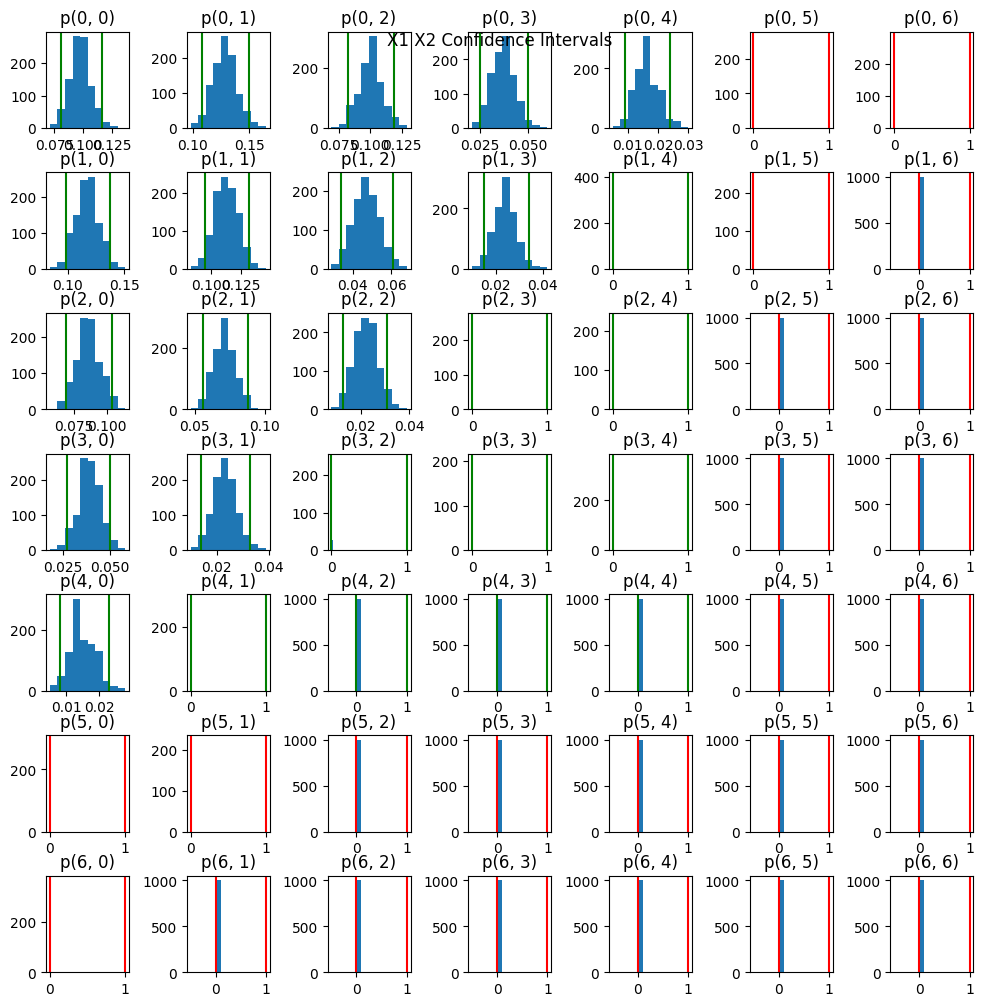

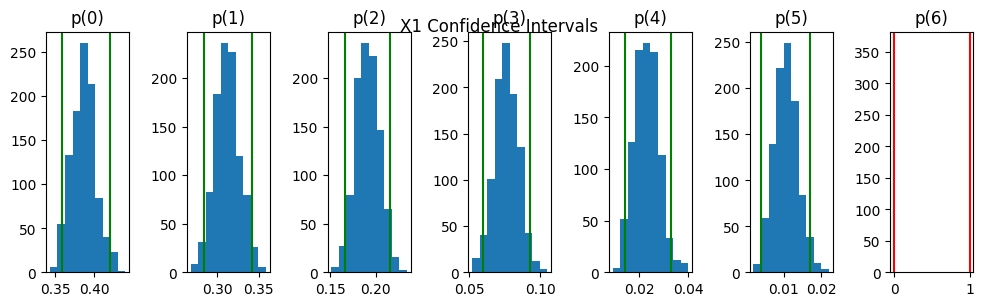

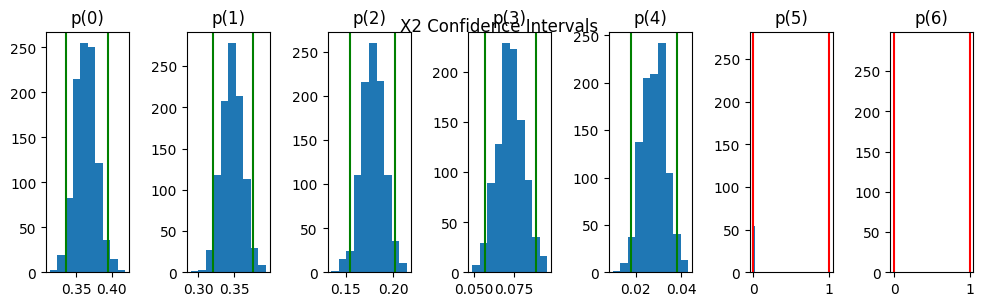

Box truncation: [0, 4] x [0, 4]
Marginal x1 truncation: [0, 5]
Marginal x2 truncation: [0, 4]


In [24]:
bounds = bootstrap(samples['OB'], BS=1000, thresh_OB=10, plot=True, printing=True)

Note that the observed truncations for joint and marginal distributions do not neccessarily match:

e.g. the states $x_{1} = 5$ and $x_{2} = 4$ are each observed more than the threshold number of times, but the pair $(5, 4)$ is not and so is not included in the joint truncation

# Correlation shifting

 22%|██▏       | 22/100 [06:44<17:44, 13.64s/it] C:\Users\willi\AppData\Local\Temp\ipykernel_15732\4048187548.py:51: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_OB = scipy.stats.pearsonr(samples['x1_OB'], samples['x2_OB'])
C:\Users\willi\AppData\Local\Temp\ipykernel_15732\4048187548.py:54: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_OG = scipy.stats.pearsonr(samples['x1_OG'], samples['x2_OG'])
100%|██████████| 100/100 [59:08<00:00, 35.49s/it]


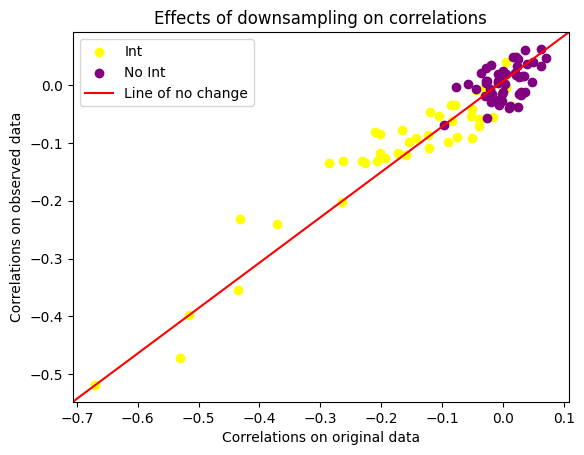

In [176]:
# size of dataset
genes = 100
cells = 1000
beta = 0.5

# correlations
correlations_Int_OB = []
correlations_Int_OG = []
correlations_noInt_OB = []
correlations_noInt_OG = []

# for each gene
for i in tqdm.tqdm(range(genes)):

    # select if interaction
    interaction = rng.choice([True, False])
    interaction_bool.append(interaction)

    # Simulate reaction rate parameters 

    # sample rates from log-uniform distribution for both genes
    log_k_tx_beta_1 = rng.uniform(0, 1.5)
    log_k_tx_beta_2 = rng.uniform(0, 1.5)
    log_k_deg_1 = rng.uniform(-1, 0)
    log_k_deg_2 = rng.uniform(-1, 0)
    if interaction: 
        log_k_reg = rng.uniform(-2, 2)

    # exponentiate and scale
    k_tx_1 = (10 ** log_k_tx_beta_1) / beta
    k_tx_2 = (10 ** log_k_tx_beta_2) / beta
    k_deg_1 = 10 ** log_k_deg_1
    k_deg_2 = 10 ** log_k_deg_2
    if interaction: 
        k_reg = 10 ** log_k_reg
    else:
        k_reg = 0

    params = {
        'k_tx_1': k_tx_1,
        'k_tx_2': k_tx_2,
        'k_deg_1': k_deg_1,
        'k_deg_2': k_deg_2,
        'k_reg': k_reg
    }

    # sample from stationary distribution
    samples = simulation(params, n=cells, beta=beta)

    # compute observed correlation
    corr_OB = scipy.stats.pearsonr(samples['x1_OB'], samples['x2_OB'])

    # compute original correlation
    corr_OG = scipy.stats.pearsonr(samples['x1_OG'], samples['x2_OG'])

    # store
    if interaction:
        correlations_Int_OB.append(corr_OB.statistic)
        correlations_Int_OG.append(corr_OG.statistic)
    else:
        correlations_noInt_OB.append(corr_OB.statistic)
        correlations_noInt_OG.append(corr_OG.statistic)

plt.scatter(correlations_Int_OG, correlations_Int_OB, color="yellow", label="Int")
plt.scatter(correlations_noInt_OG, correlations_noInt_OB, color="purple", label="No Int")
plt.xlabel("Correlations on original data")
plt.ylabel("Correlations on observed data")
plt.title("Effects of downsampling on correlations")
plt.gca().plot([0, 1], [0, 1], transform=plt.gca().transAxes, color="red", label="Line of no change")
plt.legend()
plt.show()

# Appendix: notation

We assume that the transcripts produced by genes are each independently observed with a 'capture efficiency' sometimes as low as 6%, giving a binomial relationship between the true 'original' (OG) counts and the downsampled 'observed' (OB) counts.

We denote the distribution of original (OG) counts as p (for both joint and marginal distributions) and the distribution of observed (OB) counts as q